In [16]:
import re
import time
import pyvisa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = True; plt.rc('font', size=16)
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams['figure.figsize'] = (10, 4)

from tools import *

## with direct pyvisa
tlsAddr = 'GPIB0::21::INSTR'
oscAddr = 'USB0::10893::36939::MY60340137::0::INSTR'
fgAddr = 'USB0::0x0957::0x5407::MY59000430::INSTR'

resMan = pyvisa.ResourceManager()
tlsAgilent = resMan.open_resource(tlsAddr); oscKeysight = resMan.open_resource(oscAddr); fgKeysight = resMan.open_resource(fgAddr)
print(tlsAgilent.query('*IDN?').strip()); print(oscKeysight.query('*IDN?').strip()); print(fgKeysight.query('*IDN?').strip())

## proper init both?

## params
vc = 299792458 ## m/s
nSample = 10e6 ## min number for something
samplingRateLib = [10e3, 20e3, 25e3, 40e3, 50e3, 100e3, 200e3, 400e3, 500e3, 1e6, 2e6, 2.5e6, 4e6, 5e6, 10e6, 20e6, 25e6, 40e6, 50e6, 100e6] ## automatic sampling rate

Agilent Technologies,8164B,MY48203799,V5.25(72636)
KEYSIGHT TECHNOLOGIES,MSOS804A,MY60340137,06.72.00302
Agilent Technologies,33621A,MY59000430,A.02.03-3.15-03-64-02


## piezo sweep

In [15]:
## init
lambDefault = 1550.08
ringRad = '1600'
deviceCurrent = 'D4'
mziFSR = 17.0699e6 ## in Hz, either 1.9829e6 or 17.0699e6

## FSRGuess parsing
## in nm, 0.24 for 1000nm and 0.15 for 1600nm
deviceNumber = int(re.findall(r'\d+', deviceCurrent)[0])
if 4 <= deviceNumber <= 8: ringRad = '1600SM'; FSRGuess = 0.12 
if 9 <= deviceNumber <= 17: ringRad = '1000SM'; FSRGuess = 0.19
else: ringRad = '1000MM'; FSRGuess = 0.19

# lambStart = 1545; lambEnd = 1555; tuningSpeed = 0.5 ## everything is in nm
lambStart = 1460; lambEnd = 1580; tuningSpeed = 5 ## everything is in nm
sweepLength = lambEnd-lambStart; sweepElapsed = sweepLength/tuningSpeed
sweepStep = 0.1 ## nm, keep this pls
# sweepStep = float(tlsAgilent.query(':WAV:SWE:STEP? MIN').strip())*1e9; tlsAgilent.write(':WAV:SWE:STEP 0.0001NM') ## tried to be smart

## derived
mziMinSamplingRate = 50*(tuningSpeed*1e-9/(mziFSR*(1550e-9)**2/vc))/1e6 ## MHz
numPtsMZIExpected = mziMinSamplingRate*(lambEnd-lambStart)/tuningSpeed ## MPts
numResExpected = (lambEnd-lambStart)/FSRGuess ## num of resonances
numPtsExpected = 0.5*(lambEnd-lambStart) ## MPts
print(round(numPtsMZIExpected, 2), round(numPtsExpected, 2))

oscDiv = sweepElapsed+1 ## 1s buffer after sweep is done. sanity check
oscDelay = oscDiv/2 ## delay for wavelength sweep

## tls
tlsAgilent.write(':SOUR0:POW -10DBM'); tlsAgilent.write(':SOUR0:WAV ' + str(round(lambDefault,4)) + 'NM')
tlsAgilent.write(':SOUR0:AM:SOUR 5'); tlsAgilent.write(':SOUR0:AM:STAT 1') ## wavelength locking
## osc
oscKeysight.write(':CHAN1:DISP 1'); oscKeysight.write(':CHAN2:DISP 1'); oscKeysight.write(':CHAN3:DISP 1'); oscKeysight.write(':CHAN4:DISP 1') ## all
oscKeysight.write(':TIM:RANG 105MS'); oscKeysight.write(':TIM:POS 0S') ## div and delay
oscKeysight.write(':ACQ:SRAT:ANAL:AUTO 0'); oscKeysight.write(':ACQ:POIN:AUTO 1') ## sampling rate to manual, sample points to auto
for i in samplingRateLib:
    oscKeysight.write(':ACQ:SRAT:ANAL ' + str(i))
    if float(oscKeysight.query('ACQ:POIN:ANAL?').strip()) >= 1e6: break ## highest sampling rate for 1MPts
## fg
fgKeysight.write(':FUNC RAMP'); fgKeysight.write(':FREQ 5'); fgKeysight.write(':VOLT 5'); fgKeysight.write(':FUNC:RAMP:SYMM 50'); fgKeysight.write(':OUTP 1')

## main
oscKeysight.write(':TRIG:SWE TRIG') ## arm oscilloscope trigger
oscKeysight.write(':RUN') ## i told u to arm!

43.86 60.0


6

## piezo sweep, plot and save

In [ ]:
lambCurrent = []
nResonance = 2

for i in np.arange(nResonance):
    if nResonance == 1:
        lambCurrent.append(lambDefault); break
    elif i == 0:
        lambCurrent.append(lambDefault)
        lambForward, lambBackward = lambDefault, lambDefault
        FSRGuess = fsrLambFun(lambDefault*1e-9, ringRad)*1e9
        lambForward += FSRGuess; lambBackward -= FSRGuess
    else:
        FSRGuessForward = fsrLambFun(lambForward*1e-9, ringRad)*1e9
        FSRGuessBackward = fsrLambFun(lambBackward*1e-9, ringRad)*1e9
        lambForward += FSRGuessForward; lambBackward -= FSRGuessBackward

    lambCurrent.append(lambForward); lambCurrent.append(lambBackward)
lambCurrent.sort()
# lambCurrent = np.linspace(lambDefault-np.floor(nResonance/2)*FSRGuess, lambDefault+np.floor(nResonance/2)*FSRGuess, nResonance)

for i in lambCurrent:
    fileName = deviceCurrent + '_' + str(round(i,4)) + 'nm'

    ## main
    tlsAgilent.write(':SOUR0:WAV ' + str(round(i,4)) + 'NM'); time.sleep(2) ## set wavelength
    oscKeysight.write(':SING') ## arm oscilloscope trigger
    oscKeysight.write(':RUN') ## i told u to arm!
    time.sleep(3)
    print('piezo sweep for wavelength:' + str(round(i,4)) + 'nm is done! acquiring data...')

    ## get oscilloscope traces
    oscKeysight.write(':WAV:SOUR CHAN1'); oscKeysight.query(':WAV:SOUR?')
    yChan1 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)
    oscKeysight.write(':WAV:SOUR CHAN2'); oscKeysight.query(':WAV:SOUR?')
    yChan2 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)
    oscKeysight.write(':WAV:SOUR CHAN3'); oscKeysight.query(':WAV:SOUR?')
    yChan3 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)
    oscKeysight.write(':WAV:SOUR CHAN4'); oscKeysight.query(':WAV:SOUR?')
    yChan4 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)

    xIncrement = float(oscKeysight.query(':WAV:XINCREMENT?')); xOrigin = float(oscKeysight.query(':WAV:XORIGIN?'))
    xTime = [i*xIncrement + xOrigin for i in np.arange(0, len(yChan1))]

    ## save to file
    print('saving to file...')
    dataFrame = pd.DataFrame()
    dataFrame = pd.concat([dataFrame, pd.DataFrame(np.column_stack((xTime, yChan1, yChan2, yChan3, yChan4)), columns=['Time [s]', 'Channel 1 [V]', 'Channel 2 [V]', 'Channel 3 [V]', 'Channel 4 [V]'])])
    dataFrame.to_csv(fileName + '.csv', index=False, header=True) ## csv
    # # oscKeysight.write(':DISK:SAVE:WAV ALL,"C:\\Users\\Administrator\\Desktop\\test",CSV') ## inside osc

    ## plotting
    # print('plotting...')
    # figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
    # plt.plot(xTime, yChan1, '-k', label='Ch1')
    # # plt.plot(xTime, yChan2, '-g', label='Ch2')
    # # plt.plot(xTime, yChan3, '-b', label='Ch3')
    # # plt.plot(xTime, yChan3, '-r', label='Ch4')
    # plt.grid(True); plt.xlabel('Time [s]'); plt.ylabel('Voltage [V]'); plt.legend()
    # plt.xlim([min(xTime), max(xTime)])
    # plt.show()

print('done! ready for wavelength sweep. tls trig to Ch3!')

## wavelength sweep

wavelength sweep done! check the data on the oscilloscope and confirm!
acquiring oscilloscope traces...
switch device! switch to PD! split trig to Ch3!
plotting...


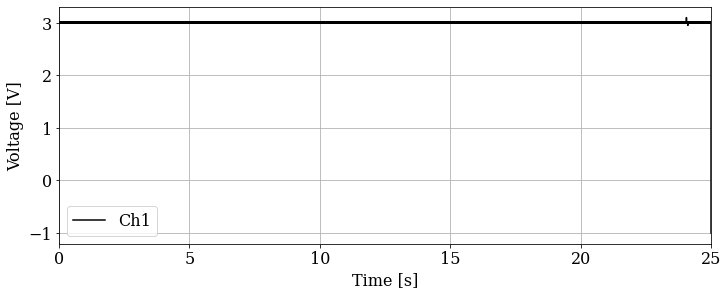

In [13]:
## init
## fg
fgKeysight.write(':OUTP 0') ## stop fg
## tls
tlsAgilent.write(':SOUR0:POW -10DBM'); tlsAgilent.write(':SOUR0:WAV ' + str(round(lambDefault,4)) + 'NM')
tlsAgilent.write(':WAV:SWE:CYCL 1')
tlsAgilent.write(':WAV:SWE:MODE CONT')
tlsAgilent.write(':WAV:SWE:REP TWOW')
tlsAgilent.write(':WAV:SWE:STAR ' + str(lambStart) + 'NM')
tlsAgilent.write(':WAV:SWE:STOP ' + str(lambEnd) + 'NM')
tlsAgilent.write(':WAV:SWE:SPE ' + str(tuningSpeed) + 'NM/S')
tlsAgilent.write(':WAV:SWE:STEP ' + str(sweepStep) + 'NM')
tlsAgilent.write(':SOUR0:AM:STAT 0') ## no modulation
tlsAgilent.write(':TRIG0:OUTP SWST') ## output trigger to sweep start
# print(tlsAgilent.query(':WAV:SWE:CHEC?').strip()) ## check everything, make sure everything is okay
# print(tlsAgilent.query('*OPC?').strip()) ## check again because im dumb
## osc
oscKeysight.write(':CHAN1:DISP 1'); oscKeysight.write(':CHAN2:DISP 1'); oscKeysight.write(':CHAN3:DISP 1'); oscKeysight.write(':CHAN4:DISP 0') ## all except 4
oscKeysight.write(':TIM:RANG ' + str(oscDiv) + 'S'); oscKeysight.write(':TIM:POS ' + str(oscDelay) + 'S') ## div and delay
# print(oscKeysight.query('*OPC?').strip()) ## check everything, make sure everything is okay
oscKeysight.write(':ACQ:SRAT:ANAL:AUTO 0'); oscKeysight.write(':ACQ:POIN:AUTO 1') ## sampling rate to manual, sample points to auto
for i in samplingRateLib:
    oscKeysight.write(':ACQ:SRAT:ANAL ' + str(i))
    if float(oscKeysight.query('ACQ:POIN:ANAL?').strip()) >= nSample: break ## highest sampling rate, with upper limit of nSample
# print(float(oscKeysight.query(':ACQ:SRAT:ANAL?').strip())); print(float(oscKeysight.query('ACQ:POIN:ANAL?').strip())) ## sanity check. because.

## main
oscKeysight.write(':SING') ## arm oscilloscope trigger
oscKeysight.write(':RUN') ## i told u to arm!
time.sleep(3)
tlsAgilent.write(':WAV:SWE STAR') ## start
time.sleep(sweepElapsed + 5)
print('wavelength sweep done! check the data on the oscilloscope and confirm!')

tlsAgilent.write(':SOUR0:WAV 1550NM') ## reset TLS wavelength

## get oscilloscope traces
print('acquiring oscilloscope traces...')
oscKeysight.write(':WAV:SOUR CHAN1'); oscKeysight.query(':WAV:SOUR?')
yChan1 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)
oscKeysight.write(':WAV:SOUR CHAN2'); oscKeysight.query(':WAV:SOUR?')
yChan2 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)
oscKeysight.write(':WAV:SOUR CHAN3'); oscKeysight.query(':WAV:SOUR?')
yChan3 = oscKeysight.query_ascii_values(':WAV:DATA?', container=np.array)

xIncrement = float(oscKeysight.query(':WAV:XINCREMENT?')); xOrigin = float(oscKeysight.query(':WAV:XORIGIN?'))
xTime = [i*xIncrement + xOrigin for i in np.arange(0, len(yChan1))]

print('switch device! switch to PD! split trig to Ch3!')

## plotting
print('plotting...')
figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
plt.plot(xTime, yChan1, '-k', label='Ch1')
# plt.plot(xTime, yChan2, '-g', label='Ch2')
# plt.plot(xTime, yChan3, '-b', label='Ch3')
plt.grid(True); plt.xlabel('Time [s]'); plt.ylabel('Voltage [V]'); plt.legend()
plt.xlim([min(xTime), max(xTime)])
plt.show()

In [14]:
## save to file
fileName = deviceCurrent + '_' + str(round(lambStart)) + 'to' + str(round(lambEnd)) + 'nm_' + str(round(tuningSpeed,1)) + 'nmps'
print('saving to file...')
dataFrame = pd.DataFrame()
dataFrame = pd.concat([dataFrame, pd.DataFrame(np.column_stack((xTime, yChan1, yChan2, yChan3)), columns=['Time [s]', 'Channel 1 [V]', 'Channel 2 [V]', 'Channel 3 [V]'])])
# dataFrame.to_csv(fileName + '.csv', index=False, header=True) ## csv
dataFrame.to_csv('Laser.csv', index=False, header=True) ## csv
# # oscKeysight.write(':DISK:SAVE:WAV ALL,"C:\\Users\\Administrator\\Desktop\\test",CSV') ## inside osc

print('piezo sweep time!')

saving to file...
piezo sweep time!


## stop piezo

In [ ]:
tlsAgilent.write(':SOUR0:WAV ' + str(round(lambDefault,4)) + 'NM') ## reset TLS wavelength
tlsAgilent.write(':SOUR0:AM:STAT 0') ## no modulation
fgKeysight.write(':OUTP 0') ## stop fg

In [ ]:
## close
oscKeysight.close()
fgKeysight.close()
tlsAgilent.close()